# Mentoría

## Introduccion al Aprendizaje Automático

### Introducción

En la siguiente notebook se presentará la consigna a seguir para el tercer práctico del proyecto, correspondiente a la materia Introducción al Aprendizaje Automático. El objetivo consiste en explorar la aplicación de diferentes métodos de aprendizaje supervisado aprendidos en el curso, a través de experimentos reproducibles, y evaluando a su vez la conveniencia de uno u otro, así como la selección de diferentes hiperparámetros a partir del cálculo de las métricas pertinentes.

En el caso de nuestro proyecto, nos enfrentamos originalmente a un problema de prediccion. Sin embargo, a los fines de este práctico, lo transformaremos en un problema de clasificación binario, adaptando las el feature objetivo del dataset. Además, será importante evaluar el desbalance de clases y qué decisiones tomaremos al respecto.

Para ello, comenzaremos con las importaciones pertinentes.


### Importaciones

In [100]:
# Importación de las librerías necesarias
import numpy as np
import pandas as pd
# Puede que nos sirvan también
import matplotlib as mpl
mpl.get_cachedir()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn as skl

from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression, Perceptron, Ridge
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, classification_report, roc_curve, auc
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

from sklearn import metrics

np.random.seed(0)  # Para mayor determinismo

In [101]:
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)
pd.set_option('max_colwidth', 151)

## Consigna para Introducción al Aprendizaje Automático

### I. Preprocesamiento

A los fines de realizar este práctico, se utilizará el dataset original.La división entre train y test será realizada en este mismo práctico. A continuación se detallan los pasos a seguir para el preprocesamiento de los datos.

1. Obtención del Dataset

Cargar el conjunto de entrenamiento original.


In [102]:
#Parsing auxiliar
dateparse = lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

_ds_energia = pd.read_csv('https://raw.githubusercontent.com/alaain04/diplodatos/master/data/energia_completo.csv')
_ds_energia['hora'] = _ds_energia.Fecha.apply(lambda x: x[11:13])
_ds_energia['Fecha'] = pd.to_datetime(_ds_energia['Fecha'],format='%Y-%m-%d %H:%M:%S')
_ds_energia.head(5)

,Fecha,Amper_fase_T_A,Amper_fase_S_A,Amper_fase_R_A,Vab,Vca,Vbc,Kwatts_3_fases,Factor_de_Poten_A,hora
0,2019-12-03 20:45:00,11,11,12,2147483.65,42.16,40.94,-2.147484e+09,0.00,20
1,2019-12-03 20:50:00,11,11,11,0.00,2147483.65,0.00,-2.147484e+09,0.00,20
2,2019-12-03 20:55:00,11,11,12,2147483.65,2147483.65,2147483.65,-2.147484e+09,-0.93,20
3,2019-12-03 21:00:00,11,11,11,2147483.65,0.00,2147483.65,0.000000e+00,0.00,21
4,2019-12-03 21:05:00,10,10,11,35.78,36.54,0.00,-4.342000e+03,-0.51,21


In [103]:
#Elimino datos del día 3/12/2019 para comenzar un dia completo
_ds_energia.drop(_ds_energia[pd.to_datetime(_ds_energia['Fecha'].dt.date)=='2019-12-03'].index,inplace=True)


In [104]:
#Generamos Period Index y ordenamos el dataset de Energia
_ds_energia.index = pd.PeriodIndex(list(_ds_energia['Fecha']), freq='05T')
_ds_energia = _ds_energia.sort_index()


In [105]:
# _ds_clima
_ds_clima = pd.read_csv('https://raw.githubusercontent.com/alaain04/diplodatos/master/data/clima_posadas_20192020.csv')
_ds_clima['time'] = pd.to_datetime(_ds_clima['time'],format='%Y-%m-%d %H:%M:%S')
#Elegimos features del dataset de Clima y los llevamos cada 5 minutos para poder unirlo con el dataset de energia
_ds_clima.index = pd.PeriodIndex(list(_ds_clima['time']), freq='T')
_ds_clima = _ds_clima[['temperature','windspeed','winddirection']].resample('05T').fillna("backfill")
#Ordenamos valores
_ds_clima = _ds_clima.sort_index()

#####Unimos ambos datasets

In [106]:
_ds_energia=_ds_energia.join(_ds_clima,how='left')
_ds_energia.head()

,Fecha,Amper_fase_T_A,Amper_fase_S_A,Amper_fase_R_A,Vab,Vca,Vbc,Kwatts_3_fases,Factor_de_Poten_A,hora,temperature,windspeed,winddirection
2019-12-04 00:00,2019-12-04 00:00:00,9,9,10,2147483.65,2147483.65,2147483.65,-2.147484e+09,0.0,00,26.7,9.4,230.0
2019-12-04 00:05,2019-12-04 00:05:00,9,10,10,2147483.65,2147483.65,2147483.65,-2.147484e+09,0.0,00,25.8,9.4,140.0
2019-12-04 00:10,2019-12-04 00:10:00,9,9,10,2147483.65,2147483.65,2147483.65,-2.147484e+09,0.0,00,25.8,9.4,140.0
2019-12-04 00:15,2019-12-04 00:15:00,9,9,10,2147483.65,2147483.65,2147483.65,-2.147484e+09,0.0,00,25.8,9.4,140.0
2019-12-04 00:20,2019-12-04 00:20:00,9,9,10,2147483.65,2147483.65,2147483.65,-2.147484e+09,0.0,00,25.8,9.4,140.0



2. Aplicar Script de Curación

Inicialmente, luego de haber unido ambos datasets, con el objetivo de preparar los datos que alimentarán los modelos de aprendizaje automático (ML) propuestos, deberán aplicar el script de curación obtenido en el práctico anterior. En esta etapa, pueden adicionar los atributos que crean pertinentes a priori o que hayan encontrado interesantes por tener mayor correlación con la variable Target.



In [107]:
#Calculamos los valores absolutos de la Potencia
_ds_energia['abs_Kwatts'] = _ds_energia['Kwatts_3_fases'].abs()

#Calculamos los valores absolutos de la Potencia
_ds_energia['abs_Potencia'] = _ds_energia['Factor_de_Poten_A'].abs()

#Creamos un campo con la fecha del día solamente
_ds_energia['fecha_dia'] = pd.to_datetime(_ds_energia['Fecha'].dt.date) 

_ds_energia['DiaSemana'] = pd.to_datetime(_ds_energia.fecha_dia.dt.date).dt.day_name()
_ds_energia['mes_desc'] = pd.to_datetime(_ds_energia.fecha_dia.dt.date).dt.month_name()

In [108]:
def get_dia_laboral(nombre_dia):
    if nombre_dia in ['Wednesday', 'Thursday', 'Friday', 'Monday','Tuesday']:
        return 'Dia laboral'
    else:
        return 'Fin de semana'

In [109]:
_ds_energia['es_dia_laboral'] = _ds_energia['DiaSemana'].apply(lambda x:get_dia_laboral(x))

In [110]:
# instanciamos clases
le_dia_semana = preprocessing.LabelEncoder()
le_dia_laboral = preprocessing.LabelEncoder()

In [111]:
# Ejecutamos la funcion entrena el modelo de codificación
le_dia_semana.fit(_ds_energia['DiaSemana'])
le_dia_laboral.fit(_ds_energia['es_dia_laboral'])

LabelEncoder()

In [112]:
# View encoder mapping
dict(zip(le_dia_semana.classes_,le_dia_semana.transform(le_dia_semana.classes_)))

{'Friday': 0,
 'Monday': 1,
 'Saturday': 2,
 'Sunday': 3,
 'Thursday': 4,
 'Tuesday': 5,
 'Wednesday': 6}

In [113]:
dict(zip(le_dia_laboral.classes_,le_dia_laboral.transform(le_dia_laboral.classes_)))

{'Dia laboral': 0, 'Fin de semana': 1}

In [114]:
# transfomr -> ejecuta el modelo y retorna el array con los datos transformados

_ds_energia['DiaSemana_Transform'] = le_dia_semana.transform(_ds_energia['DiaSemana']) 
_ds_energia['Es_dia_laboral_Transform'] = le_dia_laboral.transform(_ds_energia['es_dia_laboral']) 


In [115]:
# obtengo lista de registros outliers
outl = _ds_energia[_ds_energia.abs_Kwatts > (_ds_energia.abs_Kwatts.median() + 3 * _ds_energia.abs_Kwatts.median())] 
_valor_outlier = _ds_energia.abs_Kwatts.median() + 3 * _ds_energia.abs_Kwatts.median()
print('Límite máximo de consumo para considerar outliers: ' + str(_valor_outlier) )

Límite máximo de consumo para considerar outliers: 14280.0


In [116]:
#Reemplazamos Nan en tensiones
_ds_energia.loc[ ( _ds_energia['Vab'].isna()), 'Vab'] = 0
_ds_energia.loc[ ( _ds_energia['Vca'].isna()), 'Vca'] = 0
_ds_energia.loc[ ( _ds_energia['Vbc'].isna()), 'Vbc'] = 0
#Reemplazamos outliers en tensiones
_ds_energia.loc[ ( _ds_energia['Vab'] > _ds_energia.Vab.median() + 3 * _ds_energia.Vab.median() ), 'Vab'] = 0 #_ds_energia.Vab.median() + 3 * _ds_energia.Vab.median()
_ds_energia.loc[ ( _ds_energia.Vca > _ds_energia.Vca.median() + 3 * _ds_energia.Vca.median() ) , 'Vca'] = 0 #_ds_energia.Vca.median() + 3 * _ds_energia.Vca.median()
_ds_energia.loc[ ( _ds_energia['Vbc'] > _ds_energia.Vbc.median() + 3 * _ds_energia.Vbc.median() ), 'Vbc'] = 0 #_ds_energia.Vbc.median() + 3 * _ds_energia.Vbc.median()

In [117]:
# convertimos los nan de abs_Kwatts en valor 0 si es nan 'Kwatts 3 fases' y 'Amper fase T-A'== 0, luego se marcará como un corte de energia
_ds_energia.loc[ ( _ds_energia['Amper_fase_R_A'].isna()) & (_ds_energia['Amper_fase_T_A'] == 0), 'Amper_fase_R_A'] = 0
_ds_energia.loc[ ( _ds_energia['Amper_fase_S_A'].isna()) & (_ds_energia['Amper_fase_T_A'] == 0), 'Amper_fase_S_A'] = 0
_ds_energia.loc[ ( _ds_energia['Kwatts_3_fases'].isna()) & (_ds_energia['Amper_fase_T_A'] == 0), 'abs_Kwatts'] = 0

In [118]:
#Evaluamos si hubo un corte de energia (o sea, si la potencia total es igual a 0)
_ds_energia.loc[_ds_energia.abs_Kwatts == 0, 'corte_energia'] = 1
_ds_energia.loc[(_ds_energia['Factor_de_Poten_A']<=0) & (_ds_energia['Kwatts_3_fases']>0),
                                               'corte_energia'] = 1
_ds_energia.loc[(_ds_energia['Factor_de_Poten_A']>0) & (_ds_energia['Kwatts_3_fases']<0),
                                               'corte_energia'] = 1                                               

_ds_energia.loc[_ds_energia.abs_Kwatts != 0, 'corte_energia'] = 0

_ds_energia.loc[_ds_energia.Vca == 0, 'corte_energia'] = 1
_ds_energia.loc[_ds_energia.Vab == 0, 'corte_energia'] = 1
_ds_energia.loc[_ds_energia.Vbc == 0, 'corte_energia'] = 1

_ds_energia.loc[_ds_energia['Amper_fase_R_A'] == 0, 'corte_energia'] = 1
_ds_energia.loc[_ds_energia['Amper_fase_T_A'] == 0, 'corte_energia'] = 1
_ds_energia.loc[_ds_energia['Amper_fase_S_A'] == 0, 'corte_energia'] = 1


#Cambiamos outliers sólo en columna nueva
#Evaluamos si hay los outliers de la potencia
_ds_energia.loc[_ds_energia.abs_Kwatts > _valor_outlier, 'outlier_Kwatts'] = 1
_ds_energia.loc[_ds_energia.abs_Kwatts <= _valor_outlier, 'outlier_Kwatts'] = 0


#Decidimos reemplazar los valores outliers de Potencia por 0 ya que consideramos que fue un error de medición y que para poder graficar los datos, necesitamos que no estén.
_ds_energia.loc[_ds_energia['outlier_Kwatts']==1, 'abs_Kwatts'] = 0

_ds_energia.abs_Kwatts.fillna(value=0,inplace=True)
_ds_energia.winddirection.fillna(value=0,inplace=True)
_ds_energia.windspeed.fillna(value=0,inplace=True)

In [120]:
#Verifico Nan
_ds_energia[_ds_energia.abs_Kwatts.isna()==True].abs_Kwatts.count()

0

3. Dataset para Problema de Clasificación Binario

Si bien nuestro problema original implica predecir una variable Real, es decir una regresión, comenzaremos por tratarlo como un problema de clasificación binario, en donde nuestro objetivo será:

- 1 = Hay distribución de energía (Kw 3 fases > 100)
- 0 = No hay distribución de energía  (Kw 3 fases <= 100)

Es decir, queremos diferenciar los momentos en que hay cortes en la distribucion de energia de los que no hay. En base a esta definición, deben transformar el dataset para adaptarlo a un problema de clasifiación binario.
¿Cómo luce ahora el balance de clases? ¿Tomarán alguna decisión al respecto?


In [121]:
#Creamos la columna target seteando un 1 suponiendo que hay energia, para luego evaluar la columna de potencia y asignarle 0 en caso contrario
_ds_energia['target'] = 1
_ds_energia.loc[_ds_energia.abs_Kwatts <= 100, 'target'] = 0
_ds_energia.loc[_ds_energia.corte_energia==1, 'target'] = 0


In [122]:
print('Porcentaje de valor 1 (con distribución de energia) ' + str(_ds_energia[_ds_energia.target==1].Fecha.count()/_ds_energia.Fecha.count()))
print('Porcentaje de valor 0 (sin distribución de energia) ' + str(_ds_energia[_ds_energia.target==0].Fecha.count()/_ds_energia.Fecha.count()))

Porcentaje de valor 1 (con distribución de energia) 0.5311325654578228
Porcentaje de valor 0 (sin distribución de energia) 0.46886743454217716


4. *Normalización de Atributos*

Es posible que sea necesario normalizar las features de nuestro dataset, dado que muchos de los algoritmos de clasificación supervisada lo requieren. ¿En qué casos tendrá que implementarse normalización?

Aplicar a los datasets la normalización de atributos que consideren adecuada.

In [123]:
_ds_energia.dtypes

Fecha                       datetime64[ns]
Amper_fase_T_A                       int64
Amper_fase_S_A                       int64
Amper_fase_R_A                       int64
Vab                                float64
Vca                                float64
Vbc                                float64
Kwatts_3_fases                     float64
Factor_de_Poten_A                  float64
hora                                object
temperature                        float64
windspeed                          float64
winddirection                      float64
abs_Kwatts                         float64
abs_Potencia                       float64
fecha_dia                   datetime64[ns]
DiaSemana                           object
mes_desc                            object
es_dia_laboral                      object
DiaSemana_Transform                  int64
Es_dia_laboral_Transform             int64
corte_energia                      float64
outlier_Kwatts                     float64
target     

In [124]:
#Funcion para normalizar los campos numéricos de 0 a 1
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [125]:
dt_normalizado = normalize(_ds_energia.drop(columns=['Kwatts_3_fases','Factor_de_Poten_A','outlier_Kwatts','corte_energia','es_dia_laboral','mes_desc','DiaSemana','fecha_dia','hora','Fecha']))
dt_normalizado.sample(5)

,Amper_fase_T_A,Amper_fase_S_A,Amper_fase_R_A,Vab,Vca,Vbc,temperature,windspeed,winddirection,abs_Kwatts,abs_Potencia,DiaSemana_Transform,Es_dia_laboral_Transform,target
2019-12-28 21:15,0.000000,0.000000,0.000000,0.627813,0.636568,0.626986,0.885057,0.000000,0.000000,0.704782,0.909091,0.333333,1.0,0.0
2020-04-26 21:20,0.000000,0.000000,0.000000,0.698488,0.717541,0.702217,0.545977,0.202166,0.388889,0.476909,0.979798,0.500000,1.0,0.0
2020-02-04 05:50,0.176471,0.170455,0.157895,0.703411,0.719268,0.676907,0.626437,0.032491,0.250000,0.538174,0.949495,0.833333,0.0,1.0
2019-12-15 19:30,0.000000,0.000000,0.000000,0.678446,0.685083,0.649328,0.511494,0.137184,0.944444,0.414825,0.959596,0.500000,1.0,0.0
2020-03-05 13:45,0.223529,0.215909,0.200000,0.000000,0.000000,0.000000,0.683908,0.202166,0.250000,0.476207,0.898990,0.666667,0.0,0.0


In [126]:
#Funcion para normalizar los campos numéricos de -1 a 1
def normalize_alternativa(df):
    result = df.copy()
    for feature_name in df.columns:
        if feature_name != 'target':
            _mean = df[feature_name].mean()
            _std = df[feature_name].std()
            result[feature_name] = (df[feature_name] - _mean) / (_std)
    return result

In [127]:
dt_normalizado_alternativa = normalize_alternativa(_ds_energia.drop(columns=['Kwatts_3_fases','Factor_de_Poten_A','outlier_Kwatts','corte_energia','es_dia_laboral','mes_desc','DiaSemana','fecha_dia','hora','Fecha']))
dt_normalizado_alternativa.sample(3)

,Amper_fase_T_A,Amper_fase_S_A,Amper_fase_R_A,Vab,Vca,Vbc,temperature,windspeed,winddirection,abs_Kwatts,abs_Potencia,DiaSemana_Transform,Es_dia_laboral_Transform,target
2020-05-12 08:55,0.748229,0.830054,0.812678,0.535432,0.592421,0.590561,-0.203580,-0.136534,-0.580778,-0.341660,0.490295,0.998372,-0.631778,1
2020-05-28 17:05,1.354979,1.302490,1.343396,0.327013,0.382363,0.385062,0.488180,0.572778,-1.015661,-0.350846,-0.127704,0.499266,-0.631778,1
2020-03-29 21:20,-0.667520,-0.634500,-0.646794,-1.758945,-1.771301,-1.767991,1.047476,-0.136534,0.180268,0.940847,0.381236,0.000160,1.582811,0


In [128]:
dt_normalizado_alternativa.describe()

,Amper_fase_T_A,Amper_fase_S_A,Amper_fase_R_A,Vab,Vca,Vbc,temperature,windspeed,winddirection,abs_Kwatts,abs_Potencia,DiaSemana_Transform,Es_dia_laboral_Transform,target
count,6.546200e+04,6.546200e+04,6.546200e+04,6.546200e+04,6.546200e+04,6.546200e+04,6.546200e+04,6.546200e+04,6.546200e+04,6.546200e+04,6.531000e+04,6.546200e+04,6.546200e+04,65462.000000
mean,-1.664759e-13,5.477987e-14,9.756364e-14,-5.487731e-14,4.448995e-14,7.282800e-14,-1.441058e-13,-1.432316e-13,-2.011505e-14,-5.928136e-15,-2.453395e-13,-1.058272e-15,-4.022840e-15,0.531133
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.499034
min,-1.072020e+00,-1.059693e+00,-1.044833e+00,-1.758945e+00,-1.771301e+00,-1.767991e+00,-2.749845e+00,-1.988626e+00,-1.559265e+00,-2.292626e+00,-3.072292e+00,-1.497158e+00,-6.317778e-01,0.000000
25%,-1.072020e+00,-1.059693e+00,-1.044833e+00,2.769687e-01,2.727675e-01,2.887701e-01,-6.892834e-01,-6.094087e-01,-5.807777e-01,-4.179749e-01,1.631189e-01,-9.980517e-01,-6.317778e-01,0.000000
50%,-1.618954e-01,-2.093070e-01,-2.487564e-01,3.470305e-01,3.652387e-01,3.692086e-01,9.078637e-02,-1.365342e-01,-3.717355e-02,3.567238e-02,3.448836e-01,1.601116e-04,-6.317778e-01,1.000000
75%,7.987918e-01,8.300536e-01,8.126785e-01,4.765565e-01,4.970956e-01,4.731329e-01,7.383915e-01,5.727776e-01,3.977098e-01,6.101510e-01,4.539424e-01,9.983719e-01,1.582811e+00,1.000000
max,3.225791e+00,3.097749e+00,3.156680e+00,1.589891e+00,1.534827e+00,1.595750e+00,2.372123e+00,8.926894e+00,2.354685e+00,3.751058e+00,5.266482e-01,1.497478e+00,1.582811e+00,1.000000


In [129]:
# división entre entrenamiento y evaluación
dt_normalizado_alternativa = dt_normalizado_alternativa.dropna()
columns=dt_normalizado_alternativa.columns
X = dt_normalizado_alternativa[columns]
y = dt_normalizado_alternativa.target

5. Mezcla Aleatória y División en Train/Test

Finalmente, están en condiciones de dividir el dataset en Train y Test, utilizando para este último conjunto un 20% de los datos disponibles. Previo a esta división, es recomendable que mezclen los datos aleatoriamente. De este modo, deberán obtener cuatro conjuntos de datos, para cada uno de los datasets: X_train, X_test, y_train y y_test.


In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

In [131]:
X_train.shape, y_train.shape

((52248, 14), (52248,))

In [132]:
X_test.shape,  y_test.shape

((13062, 14), (13062,))

In [133]:
##La proporción cambia al considerar también cortes de energía cuando las tensiones y corrientes están en 0.
##Pasamos de tener una proporción de 90/10 a 53/47
print('Proporción de valor 1 y 0 en el set de training) \n' + str(y_train.value_counts()/y_train.shape[0]) )
print('\nProporción de valor 1 y 0 en el set de testing) \n' + str(y_test.value_counts()/y_test.shape[0]) )

Proporción de valor 1 y 0 en el set de training) 
1    0.532441
0    0.467559
Name: target, dtype: float64

Proporción de valor 1 y 0 en el set de testing) 
1    0.532078
0    0.467922
Name: target, dtype: float64





6. Division en Train/Test (opcional)

En muchos de los problemas de series temporales la variable objetivo está muy ligada al momento en la cual se la mide. Es por esto que se suele adoptar diferentes estrategias para la división de los dataset de de entrenamiento y test. 

La opción más frecuente es dividirlos en subconjuntos ordenados por el tiempo, de manera que el dataset de entrenamiento sea anterior al de test.

Prueben realizar esta división y ejecutar los mismos modelos para poder comparar resultados sobre las métricas obtenidas.

https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/


A modo de ayuda, en esta notebook encontrarán una especie de template que sigue los pasos propuestos y que deberán ir completando.

Recuerden que la ciencia de datos es un proceso circular, continuo y no lineal. Es decir, si los datos requieren de mayor procesamiento para satisfacer las necesidades de algoritmos de ML (cualesquiera de ellos), vamos a volver a la etapa inicial para, por ejemplo, crear nuevas features, tomar decisiones diferentes sobre valores faltantes o valores atípicos (outliers), descartar features, entre otras.

### II. Aplicación de Modelos de Clasificación

Una vez finalizada la etapa de preprocesamiento, se propone implementar diferentes modelos de clasificación para ambos datasets, utilizando la librería Scikit-Learn:

    Perceptron. Utilizar el método Stochastic Gradient Descent (Recuerden mezclar aleatoriamente los datos antes de cada iteración)
    K Nearest Neighbors ó K Vecinos Más Cercanos
    Regresión Logística. Utilizar el método Stochastic Gradient Descent (Recuerden mezclar aleatoriamente los datos antes de cada iteración)

Para cada uno de ellos, se pide responder las siguientes consignas:

    Utilizar dos features para graficar las clases y la frontera de decisión, siempre que sea posible.
    Agregar vector de Bias, cuando lo crean pertinente. Cuándo hace falta y cuándo no? Por qué?
    Obtener accuracy o exactitud.

De estos tres tipos de modelos, cuál creen que es el más adecuado para nuestro caso de aplicación?

Elegir el modelo que consideren que mejor aplica a nuestro problema. Para ello, recuerden que los pasos a seguir en la selección pueden esquematizarse como sigue:
1. Descripción de la Hipótesis

¿Cuál es nuestro problema? ¿Cómo se caracteriza? ¿Cuál es la hipótesis?

**El problema esta enfocado en determinar si el servicio de distribución de energía se encuentra activo o cortado.  El valor a predecir es de tipo binario donde el valor 1 corresponde a servicio activo y el valor 0 indica que hubo un corte.**

2. Selección de Regularizador

¿Utilizarán algún regularizador?¿Cuál?

**Si bien no seleccionamos ningún regulizador fijo, con la selección de los mejores hiperparámetros se termina utilizando el regulador L1.**

3. Selección de Función de Costo

¿Cuál será la función de costo utilizada?

**Para la regresión logística utilizando la logarítmica o sigmoide y para Perceptrón, su función homónima.**

4. Justificación de las Selecciones

¿Por qué eligieron el modelo, el regularizador y la función de costo previas?

**Para el tipo de problema binario, los modelos que mejores se adaptan son la regresión logística y el perceptrón.**

Finalmente, para el modelo selecionado:

    Utilizar el método Grid Search, o de búsqueda exahustiva, con cross-validation para profundizar en la búsqueda y selección de hiperparámetros.
    Calcular métricas sobre el conjunto de entrenamiento y de evaluación para los mejores parámetros obtenidos:
        Accuracy o exactitud
        Reporte de clasificación
        Confusion matrix o matriz de confusión (graficar como heatmap)
        Curva ROC y área bajo la curva (AUC).

**Verifico la correlacion de las varibles para seleccionar 2 que no tengan mucho correlacion**

In [154]:
# división entre entrenamiento y evaluación
dt_normalizado = dt_normalizado.dropna()

X = dt_normalizado.iloc[:, dt_normalizado.columns != 'target']
y = dt_normalizado.target

# división entre entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

In [155]:
display(X_train.shape, y_train.shape)
display(X_test.shape,  y_test.shape)

(52248, 13)

(52248,)

(13062, 13)

(13062,)

In [157]:
print('Proporción de valor 1 y 0 en el set de training) \n' + str(y_train.value_counts()/y_train.shape[0]) )
print('\nProporción de valor 1 y 0 en el set de testing) \n' + str(y_test.value_counts()/y_test.shape[0]) )

Proporción de valor 1 y 0 en el set de training) 
1.0    0.532441
0.0    0.467559
Name: target, dtype: float64

Proporción de valor 1 y 0 en el set de testing) 
1.0    0.532078
0.0    0.467922
Name: target, dtype: float64


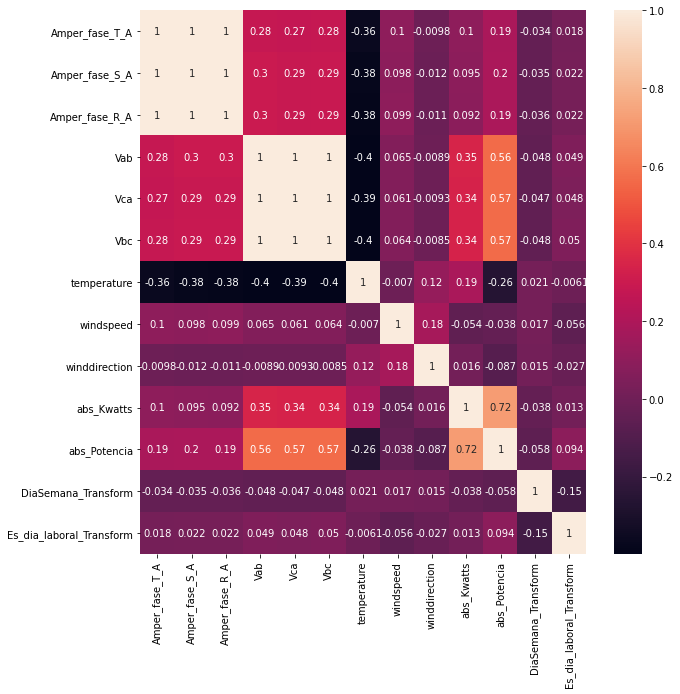

In [158]:
#Matriz de correlación
plt.figure(figsize=(10,10))
sns.heatmap(X_train.corr(), annot=True)

In [159]:
X_train = X_train[['abs_Kwatts',  'temperature']]
X_test = X_test[['abs_Kwatts',  'temperature']]

In [160]:
#Modelos con valores default
_cant_grupos = 10


model_perceptron = SGDClassifier(random_state=0, loss='perceptron')
model_reg_log = SGDClassifier(random_state=0, loss='log')
model_kn = KNeighborsClassifier(n_neighbors = _cant_grupos)

In [161]:
model_perceptron.fit(X_train, y_train)
model_reg_log.fit(X_train, y_train)
model_kn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [162]:
y_train_pred_perceptron = model_perceptron.predict(X_train)
y_train_pred_reg_log = model_reg_log.predict(X_train)
y_train_pred_kn = model_kn.predict(X_train)

y_pred_perceptron = model_perceptron.predict(X_test)
y_pred_reg_log = model_reg_log.predict(X_test)
y_pred_kn = model_kn.predict(X_test)

In [62]:
#Accuracy o exactitud
#Reporte de clasificación
#Confusion matrix o matriz de confusión (graficar como heatmap)
#Curva ROC y área bajo la curva (AUC).

In [163]:
print(f"Accuracy Perceptron: Train {accuracy_score(y_train, y_train_pred_perceptron)} - Test {accuracy_score(y_test, y_pred_perceptron)}")
print(f"Accuracy Reg Logistica: Train {accuracy_score(y_train, y_train_pred_reg_log)} - Test {accuracy_score(y_test, y_pred_reg_log)}")
print(f"Accuracy K Vecinos: Train {accuracy_score(y_train, y_train_pred_kn)} - Test {accuracy_score(y_test, y_pred_kn)}")

Accuracy Perceptron: Train 0.4863535446332874 - Test 0.4853774307150513
Accuracy Reg Logistica: Train 0.6167317409278824 - Test 0.6084060633899863
Accuracy K Vecinos: Train 0.8401278517838003 - Test 0.8013321084060634


In [164]:
print("Reporte clasificacion test PERCEPTRON")
print(classification_report(y_test, y_pred_perceptron))

Reporte clasificacion test PERCEPTRON
              precision    recall  f1-score   support

         0.0       0.48      1.00      0.65      6112
         1.0       1.00      0.03      0.06      6950

    accuracy                           0.49     13062
   macro avg       0.74      0.52      0.35     13062
weighted avg       0.75      0.49      0.34     13062



In [165]:
print("Reporte clasificacion test REG LOGISTICA")
print(classification_report(y_test, y_pred_reg_log))

Reporte clasificacion test REG LOGISTICA
              precision    recall  f1-score   support

         0.0       0.59      0.55      0.57      6112
         1.0       0.62      0.66      0.64      6950

    accuracy                           0.61     13062
   macro avg       0.61      0.60      0.60     13062
weighted avg       0.61      0.61      0.61     13062



In [166]:
print("Reporte clasificacion test KN VECINOS")
print(classification_report(y_test, y_pred_kn))

Reporte clasificacion test KN VECINOS
              precision    recall  f1-score   support

         0.0       0.77      0.82      0.79      6112
         1.0       0.83      0.79      0.81      6950

    accuracy                           0.80     13062
   macro avg       0.80      0.80      0.80     13062
weighted avg       0.80      0.80      0.80     13062



In [167]:
print("Matriz de confución PERCEPTRON")
cm =confusion_matrix(y_test, y_pred_perceptron)
display(cm)

print("Matriz de confución REG LOGISTICA")
cm =confusion_matrix(y_test, y_pred_reg_log)
display(cm)

print("Matriz de confución KN VECINOS")
cm =confusion_matrix(y_test, y_pred_kn)
display(cm)

Matriz de confución PERCEPTRON


array([[6112,    0],
       [6722,  228]])

Matriz de confución REG LOGISTICA


array([[3355, 2757],
       [2358, 4592]])

Matriz de confución KN VECINOS


array([[4992, 1120],
       [1475, 5475]])

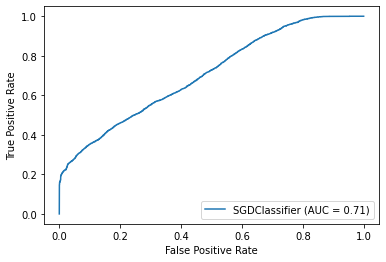

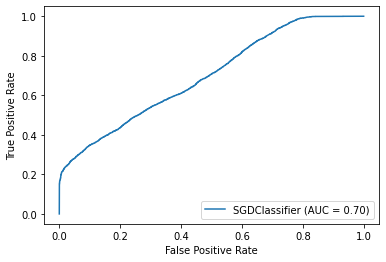

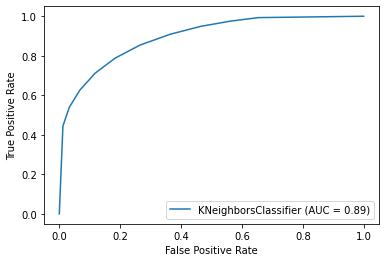

In [168]:
#curva roc/auc

metrics.plot_roc_curve(model_perceptron, X_test, y_test) 
metrics.plot_roc_curve(model_reg_log, X_test, y_test) 
metrics.plot_roc_curve(model_kn, X_test, y_test)
plt.show()  

In [69]:
#Modelos con busqueda de hiperparametros

In [169]:
param_grid = {
    'loss': ['hinge', 'log','squared_hinge'],
    'penalty': ['l2', 'l1',],
    'alpha': [.00001,.0001, .001],
    'learning_rate': ['constant','optimal','adaptive'],
    'eta0':[.0001],
}

In [170]:
model = SGDClassifier(random_state=0,shuffle=True)
model_gscv = GridSearchCV(model,param_grid,scoring='precision',cv=5)

In [171]:
model_gscv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5, random_state=0,
                                     shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-05, 0.0001, 0.001], 'eta0': [0.0001],
                         'learning_rate': ['constant', 'optimal', 'adaptive'],
                         'loss': ['hinge', 'log', 'square

In [172]:
display(model_gscv.best_estimator_)
display(model_gscv.best_params_)

SGDClassifier(alpha=0.001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0001,
              fit_intercept=True, l1_ratio=0.15, learning_rate='optimal',
              loss='hinge', max_iter=1000, n_iter_no_change=5, n_jobs=None,
              penalty='l1', power_t=0.5, random_state=0, shuffle=True,
              tol=0.001, validation_fraction=0.1, verbose=0, warm_start=False)

{'alpha': 0.001,
 'eta0': 0.0001,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'penalty': 'l1'}

In [173]:
print(model_gscv.best_estimator_.score(X_train, y_train))
y_pred_hiperparametros = model_gscv.best_estimator_.predict(X_test)

0.6285790843668657


In [174]:
print(f"Accuracy hiperparametro: Train {accuracy_score(y_train, y_train)} - Test {accuracy_score(y_test, y_pred_hiperparametros)}")

Accuracy hiperparametro: Train 1.0 - Test 0.6216505894962486


In [175]:
print("Reporte clasificacion test HIPERPARAMETROS")
print(classification_report(y_test, y_pred_hiperparametros))

Reporte clasificacion test HIPERPARAMETROS
              precision    recall  f1-score   support

         0.0       0.61      0.55      0.57      6112
         1.0       0.63      0.69      0.66      6950

    accuracy                           0.62     13062
   macro avg       0.62      0.62      0.62     13062
weighted avg       0.62      0.62      0.62     13062



In [176]:
print("Matriz de confución HIPERPARAMETROS")
cm =confusion_matrix(y_test, y_pred_hiperparametros)
display(cm)

Matriz de confución HIPERPARAMETROS


array([[3341, 2771],
       [2171, 4779]])

In [177]:
#Modelos con busqueda de hiperparametros para KNeighborsClassifier
_cant_grupos = list(range(6,10))

In [178]:
param_grid = {
    'n_neighbors': _cant_grupos,
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1,2]
}

In [179]:
model_KN = KNeighborsClassifier()
model_gscv_KN = GridSearchCV(model_KN,param_grid,scoring='precision',cv=5)

In [180]:
model_gscv_KN.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [6, 7, 8, 9], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='precision', verbose=0)

In [198]:
display(model_gscv_KN.best_estimator_)
display(model_gscv_KN.best_params_)

KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=6, p=1,
                     weights='uniform')

{'algorithm': 'ball_tree', 'n_neighbors': 6, 'p': 1, 'weights': 'uniform'}

In [196]:
y_pred_KN_hiperparametros = model_gscv_KN.best_estimator_.predict(X_test)

In [197]:
print(f"Accuracy hiperparametro KN: Train {accuracy_score(y_train, y_train)} - Test {accuracy_score(y_test, y_pred_KN_hiperparametros)}")

Accuracy hiperparametro KN: Train 1.0 - Test 0.8119736640636962


In [195]:
print("Reporte clasificacion test KN HIPERPARAMETROS")
print(classification_report(y_test, y_pred_KN_hiperparametros))

Reporte clasificacion test KN HIPERPARAMETROS
              precision    recall  f1-score   support

         0.0       0.77      0.84      0.81      6112
         1.0       0.85      0.78      0.82      6950

    accuracy                           0.81     13062
   macro avg       0.81      0.81      0.81     13062
weighted avg       0.82      0.81      0.81     13062



In [194]:
print("Matriz de confusión KN HIPERPARAMETROS")
cm =confusion_matrix(y_test, y_pred_KN_hiperparametros)
display(cm)

Matriz de confusión KN HIPERPARAMETROS


array([[5159,  953],
       [1503, 5447]])

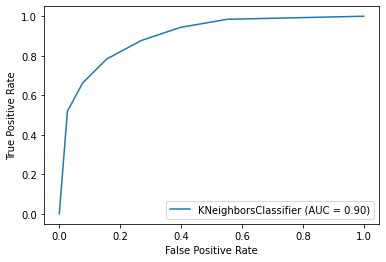

In [199]:
metrics.plot_roc_curve(model_gscv_KN.best_estimator_, X_test, y_test) 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:68: FutureWarning: Class DecisionBoundariesVisualizer is deprecated; Will be moved to yellowbrick.contrib in v0.8
  warnings.warn(msg, category=FutureWarning)


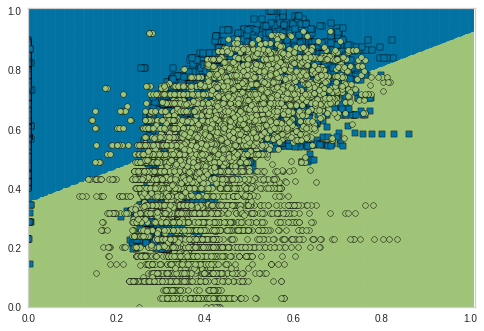

In [201]:
#Graficamos Límites de Decisión de Perceptrón
from yellowbrick.contrib.classifier import DecisionViz 
viz = DecisionViz(
    model_gscv.best_estimator_, title="Linear SVM",
    features=['Feature One', 'Feature Two'], classes=['A', 'B']
)
viz.fit(X_train.to_numpy(), y_train)
viz.draw(X_test.to_numpy(), y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:68: FutureWarning: Class DecisionBoundariesVisualizer is deprecated; Will be moved to yellowbrick.contrib in v0.8
  warnings.warn(msg, category=FutureWarning)


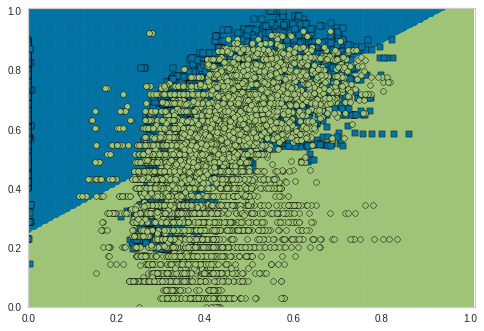

In [202]:
#Graficamos Límites de Decisión de Regresión Logística
viz = DecisionViz(
    model_reg_log, title="Linear SVM",
    features=['Feature One', 'Feature Two'], classes=['A', 'B']
)
viz.fit(X_train.to_numpy(), y_train)
viz.draw(X_test.to_numpy(), y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:68: FutureWarning: Class DecisionBoundariesVisualizer is deprecated; Will be moved to yellowbrick.contrib in v0.8
  warnings.warn(msg, category=FutureWarning)


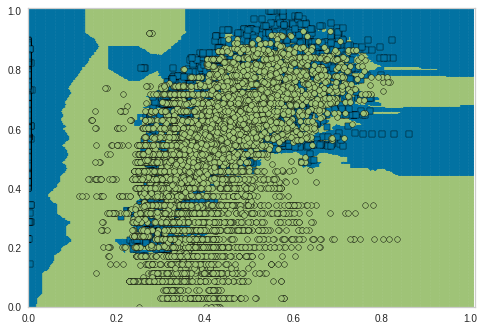

In [203]:
#Graficamos Límites de Decisión de KN
viz = DecisionViz(
    model_gscv_KN.best_estimator_, title="Nearest Neighbors",
    features=['Feature One', 'Feature Two'], classes=['A', 'B']
)
viz.fit(X_train.to_numpy(), y_train)
viz.draw(X_test.to_numpy(), y_test)

## Entregables


El entregable de este práctico consiste en esta misma Notebook, pero con el preprocesamiento aplicado y los modelos implementados, agregando las explicaciones que crean pertinentes y las decisiones tomadas, en caso de corresponder.
